In [3]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


***<p style="text-align: center;">Data Exploration</p>***



In [4]:
# set up dataframe
dfRL = pd.read_csv("BankChurn.csv")

In [5]:
# dfRl summary stats 
dfRL.describe()


,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,9999.000000,9998.000000,6383.000000,9995.000000,9998.000000,9999.000000,9998.000000,10000.000000
mean,1.569094e+07,650.528800,38.921392,5.012803,119827.493793,1.530065,0.705441,0.515052,100074.318920,0.203700
std,7.193619e+04,96.653299,10.488252,2.891910,30095.056462,0.581700,0.455867,0.499798,57504.733345,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.000000,0.000000,50983.750000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.000000,1.000000,100185.240000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.000000,1.000000,149378.722500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [6]:
# dfRL dtypes/columns 
dfRL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           9994 non-null   object 
 3   gender            9993 non-null   object 
 4   age               9999 non-null   float64
 5   tenure            9998 non-null   float64
 6   balance           6383 non-null   float64
 7   products_number   9995 non-null   float64
 8   credit_card       9998 non-null   float64
 9   active_member     9999 non-null   float64
 10  estimated_salary  9998 non-null   float64
 11  churn             10000 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 937.6+ KB


In [7]:
# find null values per column 
dfRL.isnull().sum()

customer_id            0
credit_score           0
country                6
gender                 7
age                    1
tenure                 2
balance             3617
products_number        5
credit_card            2
active_member          1
estimated_salary       2
churn                  0
dtype: int64

We have a few missing values in country, gender, age, tenure, product_number, credit_card, active_member, and estimated_salary that we will just drop, but balance is missing around 1/3 of its records. We are going to do imputation, since a large % of the records are missing. First we will look at the distribution of balance. 

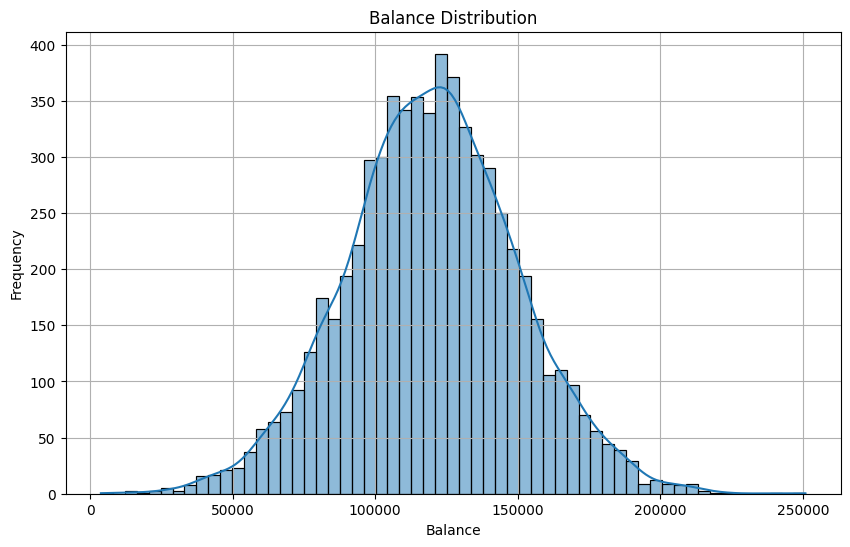

In [8]:
# histplot of balance distribution 
plt.figure(figsize=(10, 6))
sns.histplot(dfRL['balance'].dropna(), kde=True)
plt.title('Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.grid()
plt.show()



The Balance distribution is pretty uniform with a very slight skew towards the right. Given the structure of this distribution, I'll try imputation based on median to start; its important to know median imputation can reduce standard deviation and reliability. 

In [9]:
median_balance = dfRL['balance'].median()
dfRL['balance'].fillna(median_balance, inplace=True)
print(dfRL['balance'].isnull().sum())

0


C:\Users\riley\AppData\Local\Temp\ipykernel_3740\3577018127.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfRL['balance'].fillna(median_balance, inplace=True)


In [10]:
# drop rows w/ missing values
dfRL_nonull = dfRL.dropna()
dfRL = dfRL_nonull
dfRL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9985 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       9985 non-null   int64  
 1   credit_score      9985 non-null   int64  
 2   country           9985 non-null   object 
 3   gender            9985 non-null   object 
 4   age               9985 non-null   float64
 5   tenure            9985 non-null   float64
 6   balance           9985 non-null   float64
 7   products_number   9985 non-null   float64
 8   credit_card       9985 non-null   float64
 9   active_member     9985 non-null   float64
 10  estimated_salary  9985 non-null   float64
 11  churn             9985 non-null   int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 1014.1+ KB


In [11]:
# drop ID; doesnt help with the prediction model in this case
dfRL = dfRL.drop(["customer_id"], axis = 1)
dfRL.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42.0,2.0,119839.69,1.0,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1.0,119839.69,2.0,0.0,0.0,93826.63,0
4,850,Spain,Female,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0


***<p style="text-align: center;">Logistic Regression Model</p>***


In [12]:
# create dummy columns
dfRL = pd.get_dummies(dfRL, dtype = int, drop_first=True) 
dfRL

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42.0,2.0,119839.69,1.0,1.0,1.0,101348.88,1,0,0,0
1,608,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0,0,1,0
2,502,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1,0,0,0
3,699,39.0,1.0,119839.69,2.0,0.0,0.0,93826.63,0,0,0,0
4,850,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39.0,5.0,119839.69,2.0,1.0,0.0,96270.64,0,0,0,1
9996,516,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0,0,0,1
9997,709,36.0,7.0,119839.69,1.0,0.0,1.0,42085.58,1,0,0,0
9998,772,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,1,1,0,1


In [13]:
# set up IV's & DV's for the logistic regression
# y is an array of the target values
y = np.array(dfRL["churn"])

# x is a df of the needed IV's
x = dfRL[["credit_score", "age", "products_number", "credit_card", "active_member", "estimated_salary", "country_Germany", "country_Spain", "gender_Male"]]


In [14]:
# split the dataset into training and testing 
# since random sampling is used, set the random seed to a fixed value 
xRL_train, xRL_test, yRL_train, yRL_test = train_test_split(x, y, test_size = 0.30, random_state = 44)

In [15]:
# ready to run logistic regresion model
# add constatns to the independent data frames 
xRL_train = sm.add_constant(xRL_train)
xRL_test = sm.add_constant(xRL_test)

In [16]:
# fit logistic regression model and get a summary of results
modelRL = sm.Logit(yRL_train, xRL_train)
resultRL = modelRL.fit()

print(resultRL.summary())

Optimization terminated successfully.
         Current function value: 0.424381
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6989
Model:                          Logit   Df Residuals:                     6979
Method:                           MLE   Df Model:                            9
Date:                Tue, 05 Mar 2024   Pseudo R-squ.:                  0.1606
Time:                        06:25:55   Log-Likelihood:                -2966.0
converged:                       True   LL-Null:                       -3533.3
Covariance Type:            nonrobust   LLR p-value:                1.536e-238
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.3431      0.281    -11.908      0.000      -3.893      -2.793
credit_scor

In [17]:
# add predictions of the test data for the confusion matrix
xRL_test["Prediction_Prob"] = resultRL.predict(xRL_test)
xRL_test.head()

,const,credit_score,age,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male,Prediction_Prob
4843,1.0,654,29.0,1.0,1.0,0.0,37065.66,0,0,1,0.085301
6334,1.0,608,35.0,2.0,1.0,1.0,143463.28,0,1,0,0.082983
3944,1.0,612,31.0,1.0,1.0,1.0,54129.86,0,0,0,0.063221
1472,1.0,726,26.0,1.0,1.0,1.0,19225.85,0,1,0,0.042404
8517,1.0,688,20.0,2.0,1.0,1.0,197582.79,0,0,1,0.015023


In [18]:
# convert the probablities to prediction of 1 if probability >- 0.5, 0 otherwise
predictions = (xRL_test["Prediction_Prob"] >= 0.5).astype(int)
predictions

4843    0
6334    0
3944    0
1472    0
8517    0
       ..
1655    0
7596    0
1158    1
6970    1
5788    0
Name: Prediction_Prob, Length: 2996, dtype: int32

In [19]:
#compute confusion matrix
conf_matrix = metrics.confusion_matrix(yRL_test, predictions)

#extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate metrics
accuracy = accuracy_score(yRL_test, predictions)
precision = precision_score(yRL_test, predictions)
recall = recall_score(yRL_test, predictions)
f1 = f1_score(yRL_test, predictions)


print(f"Confusion Matrix: {conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")   
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Confusion Matrix: [[2284   99]
 [ 477  136]]
Accuracy: 0.807743658210948
Precision: 0.5787234042553191
Recall: 0.22185970636215335
F1 Score: 0.32075471698113206



I've playerd around with this logistic regression model a bit, dropping different IV's that were statistically insignificant such as balance and tenure. I was getting largely the same confusion matrix, so decided to chose the simpler of models. This model has a relatively high accuracy, but lower f1/precision scores which lets us know it's not the best at predicting for churn. Just to expand on this a bit, the specificty of the model is ~95%; this means that the model is really good at accurately predicting non-churn cases. However, the recall is only ~22%; this means the model is not very good at predicting churn cases. So overall the model is accurate, but that largely is inflated by the accuracy of non-churn cases. This model is a bit more conservative at predicting churn prioritizng prediciting true non-churn more than true churn. A model like this could be good if fasley identifying churn would be really problematic. 

***<p style="text-align: center;">Decision Tree Model</p>***

In [20]:
# Load and prepare dataset
dfRL1 = pd.read_csv("BankChurn.csv")
median_balance1 = dfRL1['balance'].median()
dfRL1['balance'].fillna(median_balance, inplace=True)

dfRL1 = dfRL1.dropna()

dfRL1 = dfRL1.drop(["customer_id"], axis = 1)

# preparing the dependent and independent variables
# Dummy coding using pd.get_dummies() and checking dtypes of coded variables

dfRL1 = pd.get_dummies(dfRL1, drop_first = True, dtype = int)

# make y (dependent variable) as np.array
y = np.array(dfRL1["churn"])

# make x a dataframe subset with independent variables
X = dfRL1[["credit_score", "age", "products_number", "credit_card", "active_member", "estimated_salary", "country_Germany", "country_Spain", "gender_Male", "balance", "tenure"]]

# Split dataset into training and testing data
XRL1_train, XRL1_test, yRL1_train, yRL1_test = train_test_split(X, y, test_size=0.3, random_state=42)


C:\Users\riley\AppData\Local\Temp\ipykernel_3740\1049541678.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfRL1['balance'].fillna(median_balance, inplace=True)


In [21]:
# Decision tree with gini index
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier using Gini index
dfRL1_gini = DecisionTreeClassifier(criterion='gini', random_state=42)

# Train the model
dfRL1_gini.fit(XRL1_train, yRL1_train)

# Predict the responses for test dataset
y_pred_dtRL = dfRL1_gini.predict(XRL1_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(yRL1_test, y_pred_dtRL)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(yRL1_test, y_pred_dtRL)

# Extracting TN, FP, FN, TP Values
TN, FP, FN, TP = conf_matrix.ravel()

# Print accuracy, and confusion matrix
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


Accuracy: 0.7840453938584779

Confusion Matrix:
 [[2030  344]
 [ 303  319]]
True Negatives (TN): 2030
False Positives (FP): 344
False Negatives (FN): 303
True Positives (TP): 319


ROC Area Under Curve: 0.6839793096162337


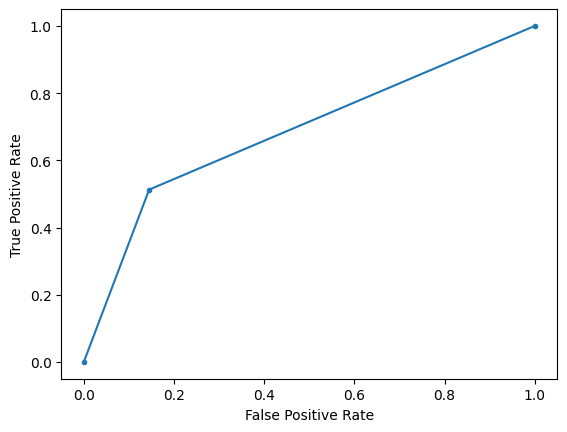

In [22]:
# Decision Tree ROC 
# roc and auc -- decision tree 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

predic_prob =dfRL1_gini.predict_proba(XRL1_test) # Probability estimates [0,1]
rf_auc = roc_auc_score(yRL1_test, predic_prob[:,1])
print("ROC Area Under Curve:", rf_auc)

# visualization of roc 
rf_fpr, rf_tpr, threshold =roc_curve(yRL1_test, predic_prob[:,1])

plt.plot(rf_fpr,rf_tpr,marker='.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

***<p style="text-align: center;">Random Forest Model</p>***

In [23]:
# Random Forest
# import Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
dfRL2 = RandomForestClassifier(n_estimators=100, random_state=10, max_depth=10, criterion='gini', )

# Train the model
dfRL2.fit(XRL1_train, yRL1_train)

# Model predictions
y_pred_rfRL = dfRL2.predict(XRL1_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(yRL1_test, y_pred_rfRL)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(yRL1_test, y_pred_rfRL)

# Extracting TN, FP, FN, TP Values
TN, FP, FN, TP = conf_matrix.ravel()

# Print accuracy, and confusion matrix
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")



Accuracy: 0.8584779706275033

Confusion Matrix:
 [[2310   64]
 [ 360  262]]
True Negatives (TN): 2310
False Positives (FP): 64
False Negatives (FN): 360
True Positives (TP): 262


In [24]:
# Random Forest
# import Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
dfRL3 = RandomForestClassifier(n_estimators=100, random_state=6, max_depth=10, criterion='entropy', )

# Train the model
dfRL3.fit(XRL1_train, yRL1_train)

# Model predictions
y_pred_rfRL = dfRL3.predict(XRL1_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(yRL1_test, y_pred_rfRL)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(yRL1_test, y_pred_rfRL)

# Extracting TN, FP, FN, TP Values
TN, FP, FN, TP = conf_matrix.ravel()

# Print accuracy, and confusion matrix
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")



Accuracy: 0.8604806408544726

Confusion Matrix:
 [[2319   55]
 [ 363  259]]
True Negatives (TN): 2319
False Positives (FP): 55
False Negatives (FN): 363
True Positives (TP): 259


Start search time: 2024-03-05 06:25:57.197531
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 350}
Best estimator: RandomForestClassifier(max_depth=9, n_estimators=350, random_state=10)
Feature importance: [0.06700714 0.33973683 0.242703   0.00789479 0.07313217 0.06379978
 0.04496908 0.00799667 0.01792029 0.09958504 0.03525522]
End search time: 2024-03-05 06:29:23.764072

Accuracy: 0.8591455273698264


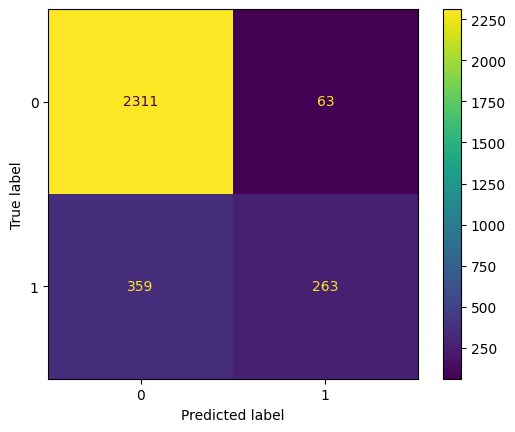

In [25]:
# Random Forest - Fine tuning with GridSearchCV
# using datetime to time the fine tuning process
from datetime import datetime
print("Start search time:", datetime.now())

from sklearn.ensemble import RandomForestClassifier

# find the best parameters 
from sklearn.model_selection import GridSearchCV

# RF -- Tunning parameters 
# Define the parameter grid
param = {
    'n_estimators': [250, 300, 350],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [7, 6, 9],  # Maximum number of levels in tree
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

RF = RandomForestClassifier(random_state=10)

# search parameters: cv=cross validation blocks; verbose=higher value show more steps
# n_jobs=-1 uses all available CPU cores; 
grid = GridSearchCV(estimator=RF, 
                    param_grid=param,
                    scoring="accuracy",
                    verbose=1, cv=5)

grid.fit(XRL1_train, yRL1_train)

print("Best parameters:", grid.best_params_)

print("Best estimator:", grid.best_estimator_)

print("Feature importance:", grid.best_estimator_.feature_importances_)

# end grid search
print("End search time:", datetime.now())

# confusion matrix 

final_model_rf = grid.best_estimator_

y_predRL = final_model_rf.predict(XRL1_test)

# get accuracy and confusion matrix
accuracy = metrics.accuracy_score(yRL1_test, y_predRL)
print("\nAccuracy:", accuracy)

cm = metrics.confusion_matrix(yRL1_test,y_predRL) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

***<p style="text-align: center;">SVM Model</p>***

In [27]:
# import SVC from sklearn
from sklearn.svm import SVC

# Initialize SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42, C = 1)

# Train the model on the training set
svm_classifier.fit(XRL1_train, yRL1_train)

# Predict the responses for the test set
y_pred_svm = svm_classifier.predict(XRL1_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(yRL1_test, y_pred_svm)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(yRL1_test, y_pred_svm)

print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.7807076101468625

Confusion Matrix:
 [[2309   65]
 [ 592   30]]


In [28]:
# import SVC from sklearn
from sklearn.svm import SVC

# Initialize SVM classifier with a linear kernel
svm_classifier = SVC(kernel='rbf', random_state=42, C = 1)

# Train the model on the training set
svm_classifier.fit(XRL1_train, yRL1_train)

# Predict the responses for the test set
y_pred_svm = svm_classifier.predict(XRL1_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(yRL1_test, y_pred_svm)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(yRL1_test, y_pred_svm)

print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.7923898531375166

Confusion Matrix:
 [[2374    0]
 [ 622    0]]


Start search time: 2024-03-05 06:35:07.039092
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
Best estimator: SVC(C=0.01, gamma=0.1)
End search time: 2024-03-05 15:55:08.474319

Accuracy: 0.7923898531375166


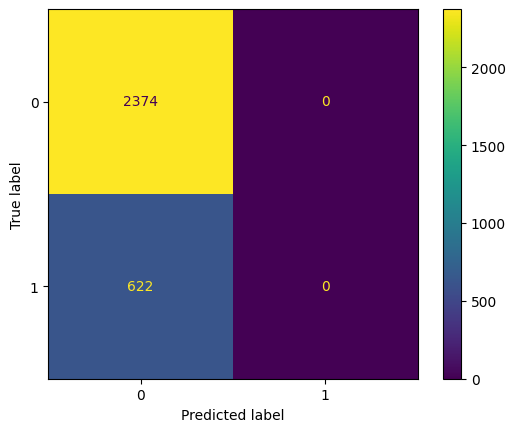

In [29]:
# SVM - Fine tuning with GridSearchCV
# using datetime to time the fine tuning process
from datetime import datetime
print("Start search time:", datetime.now())

# find the best parameters 
from sklearn.model_selection import GridSearchCV

# SVM -- Tunning parameters 
param = {
    'C':[0.01, 0.1, 1, 10, 100],
    'gamma': [0.1, 0.25, 0.5, 0.75, 1 ], # 1/n_features
    'kernel': ['rbf', 'linear'] 
}

SVM = SVC()

# search parameters: cv=cross validation blocks; verbose=higher value show more steps
# n_jobs=-1 uses all available CPU cores; 
grid = GridSearchCV(estimator=SVM, 
                    param_grid=param,
                    scoring="accuracy",
                    verbose=1, cv=5)

grid.fit(XRL1_train, yRL1_train)

print("Best parameters:", grid.best_params_)

print("Best estimator:", grid.best_estimator_)

# end grid search
print("End search time:", datetime.now())

# confusion matrix 

final_model_svmRL = grid.best_estimator_

yRL1_pred = final_model_svmRL.predict(XRL1_test)

# get accuracy and confusion matrix
accuracy = metrics.accuracy_score(yRL1_test, yRL1_pred)
print("\nAccuracy:", accuracy)

cm = metrics.confusion_matrix(yRL1_test,yRL1_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
# disp.plot()
plt.show() # display all open figures 
